# TissueMiner: Python tutorial
This tutorial is intended to demonstrate how Python can be used for visualisation and quantification of the data produced by the TissueMiner workflow. It can be run as Ipython Notebook.

Prerequisites:

    - time-lapse movies have been processed using TissueMiner workflow 

    - python libraries: numpy, matplotlib, pandas, ipython, sqlite3, rpy2

    - provided tissue_miner.py and tisue_miner_tools.py files are stored in the same folder -> no other installation is necessary

Tutorial is centered around Pandas and Matplotlib libraries. Although we provide several simple examples, basic knowledge of python and these two libraries is recommended. For a 10 minutes introduction to Pandas see: http://pandas.pydata.org/pandas-docs/stable/10min.html . Beginner guide to Matplotlib can be found here: http://matplotlib.org/users/beginner.html


Tutorial is organized in three parts:
    
    - Introduction
        
        - How to use Pandas and Matplotlib libraries for basic analysis of TissueMiner data?
    
    - Visualisation
        
        - How to visualise different cell properties on original images in cellular resolution?
    
    - Comparing movies and ROIs
        
        - How to compare data between different movies and/or regions of interest (ROIs)?

# 1 Introduction

In [1]:
# Set path to tissue_miner.py and tissue_miner_tools.py
libPath= 'lib/'

import sys
sys.path.insert(0, libPath)

import tissue_miner_tools as tml          
import tissue_miner as tm

In [2]:
import os 

# Set path to the movie databases
movieDatabaseDir='/data/biophys/mpopovic/temp/MovieRepository_DB/'

# Set relative path to the ROI file
movieRoiPath= 'roi_bt/' 
movieRoiFile= 'lgRoiSmoothed'

# Set path to output folder (optional)
outDatabaseDir= '/home/mpopovic/Dropbox/resource_paper/tutorial_output'

if not os.path.exists(outDatabaseDir):
    os.makedirs(outDatabaseDir)

In [3]:
# matplotlib magic function to enable plotting in the Notebook
%matplotlib inline  

# Import (some of) prerequisite libraries, others are used by tissue_miner and tissue_miner_tools
import os as os

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import collections as mc

from matplotlib.collections import PolyCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import pandas.io.sql as psql

## 1.1 Database and supplementary data
### Movie class
Movie class is the basic object for manipulating the data produced by TissueMiner. It is implemented in tissue_miner.py and can be simply extended by user. 
Each movie will have a dedicated instance of Movie class which is supplied with methods for loading and performing basic operations on the corresponding movie data. 

Provided version of the Movie class is provided with methods for loading SQL database tables as Pandas DataFrames. On initialization it loads cells and frames tables as well as region of interests (ROI) table if provided and reads time shifts provided in file 'PupalWingMovies.csv' which are used to synchronize movies in time.

Note that movie class will by default create pickle (.pkl) format version of both SQL tables and extra tables (see below) on the first run. This is done to reduce loading time of the data in future runs. 

In [4]:
name= 'WT_2'

# Initialization
movie= tm.Movie(name, path= movieDatabaseDir, ROI_path= movieRoiPath, ROI_filename= movieRoiFile)

Loading table frames from database WT_2...
Loading table cells from pickle file...
Loading roiBT ...


### Loading the database tables
Movie method load_DB_table(table_name) loads table named table_name from the database. Table is loaded as Pandas DataFrame object and stored in dictionary movie.DB_table.

In [5]:
movie.load_DB_table('cells')

movie.DB_table['cells'].head()

,frame,cell_id,center_x,center_y,area,elong_xx,elong_xy
0,0,10001,195.161416,1120.430486,513.0,0.150421,-0.002361
1,1,10001,187.481634,1118.081728,506.0,0.125004,-0.003316
2,2,10001,178.082442,1113.230519,492.5,0.155494,0.040019
3,3,10001,172.813431,1109.035565,538.5,0.142844,0.094702
4,4,10001,167.999972,1106.556618,488.0,0.198969,0.125119


### Loading the supplement data
In addition to the SQL database, extra tables are provided for each time-lapse movie. Each set of supplment data has a dedicated method for loading. In this tutorial we will use:

    - cellshapes.RData - cell contours by using anticlockwisely ordered cell vertices

    - ./roi_bt/lgRoiSmoothed.RData - user-defined regions of interest
    
    - ./shear_contrib/<ROI_name>/avgDeformTensorsWide.tsv - precalculated deformation rates of triangles and tissue for each region of interest

Note that some of these extra tables are provided in .RData format. On the first run these are converted to pickle format which might take some time.

In [6]:
# For example, loading cellshapes table:
movie.load_cellshapes()

movie.cellshapes.head()

Loading cellshapes of WT_2...


,frame,cell_id,x_pos,y_pos,bond_order
0,0,10001,179.102958,1118.318960,1
1,0,10001,178.519784,1125.365939,2
2,0,10001,200.016491,1133.104904,3
3,0,10001,210.582070,1125.464974,4
4,0,10001,205.758975,1111.726788,5


## 1.2 Manipulation of large data sets using Pandas library
Here we provide several simple examples of data manipulation using Pandas 

In [7]:
# We first convert cell area of each cell from pixel squared to micrometer squared by creating a new column 
# named 'realArea' to DB_table['cells'] DataFrame by multiplying 'area' column with 
# conversion factor 1pixel = 0.207 micrometers
movie.DB_table['cells']['realArea']= movie.DB_table['cells']['area']*0.207**2

movie.DB_table['cells'].head()

,frame,cell_id,center_x,center_y,area,elong_xx,elong_xy,realArea
0,0,10001,195.161416,1120.430486,513.0,0.150421,-0.002361,21.981537
1,1,10001,187.481634,1118.081728,506.0,0.125004,-0.003316,21.681594
2,2,10001,178.082442,1113.230519,492.5,0.155494,0.040019,21.103132
3,3,10001,172.813431,1109.035565,538.5,0.142844,0.094702,23.074186
4,4,10001,167.999972,1106.556618,488.0,0.198969,0.125119,20.910312


In [8]:
# We then calculate average cell area in each frame. To this end we select 'frame' and 'area columns of DB_table['cells'] 
# Dataframe and we group rows by values of 'frame' column. On each of the groups mean value of area is calculated 
movie.average_cell_area= movie.DB_table['cells'][['frame', 'realArea']].groupby('frame').agg(np.mean).reset_index().sort(columns= 'frame')

movie.average_cell_area.head()

,frame,realArea
0,0,25.231777
1,1,24.815621
2,2,24.307623
3,3,23.862201
4,4,23.441276


In [9]:
# Table 'frames' provides time elapsed between since the first frame of the movie in seconds. It is loaded by default.

movie.DB_table['frames'].head()

,frame,time_sec
0,0,0
1,1,280
2,2,561
3,3,841
4,4,1124


In [10]:
# We can now add time information to the average_cell_area DataFrame by merging it with movie.DB_table['frames'] DataFrame.
# Merging is done on column 'frame' present in both DataFrames.
movie.average_cell_area= movie.average_cell_area.merge(movie.DB_table['frames'], on= 'frame')

movie.average_cell_area.head()

,frame,realArea,time_sec
0,0,25.231777,0
1,1,24.815621,280
2,2,24.307623,561
3,3,23.862201,841
4,4,23.441276,1124


In [11]:
# New column 'time' is defined to store time information in hours
movie.average_cell_area['time']= movie.average_cell_area['time_sec']/3600.

movie.average_cell_area.head()

,frame,realArea,time_sec,time
0,0,25.231777,0,0.000000
1,1,24.815621,280,0.077778
2,2,24.307623,561,0.155833
3,3,23.862201,841,0.233611
4,4,23.441276,1124,0.312222


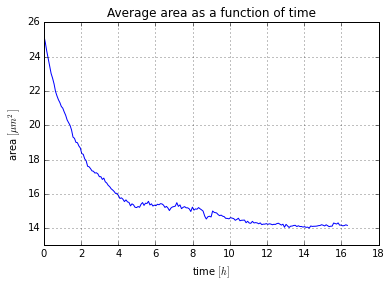

In [12]:
# We can now use DataFrame movie.average_cell_area to visualize average cell area in time using matplotlib.pyplot 
plt.plot(movie.average_cell_area['time'], movie.average_cell_area['realArea'])

plt.ylabel(r'area $[\mu m^2]$')
plt.xlabel(r'time $[h]$')
plt.title('Average area as a function of time')
plt.ylim(13, 26)
plt.grid()
plt.savefig(outDatabaseDir+'averageAreaInTime.png')

# 2 Visualization
Here we demonstrate how to load and visualise cell data on the original images.
We first show all the details on a simple example and then we use Movie.plot_frame_cells() method to visualize cell area, cell elongation, cell packnig and division patterns. All examples on are done for a single frame.

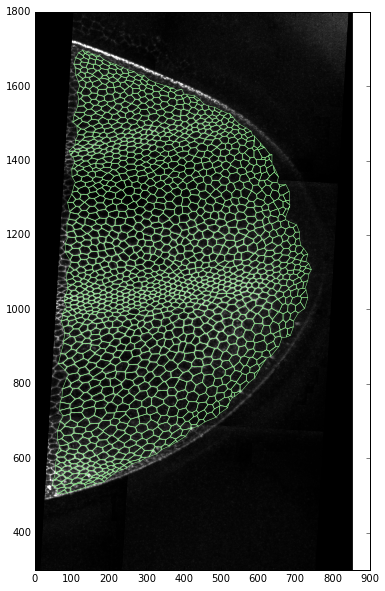

In [14]:
# We first demonstrate how to visualize cell outlines using extra table cellshapes
frame= 100

# To visualise cells we subset cellshapes table (loaded in Introduction) by the frame
movie.frame_cellshapes= tml.subset_dataframe(movie.cellshapes, ['frame'], [frame])

# Construct a list of polygon vertices for each cell
movie.frame_polygons= movie.frame_cellshapes.groupby('cell_id').apply(lambda x: zip(x['x_pos'].values, x['y_pos'].values)).reset_index().rename(columns= {0: 'plot_vertices'})

# We use matplotlib.collections to visualise a large number of polygons at once
plt.figure(figsize= (6, 10))    # define figure size
movie.show_image(frame)          # show original image of the frame     
plt.gca().autoscale_view()      
plt.gca().set_aspect('equal')   
coll= mc.PolyCollection(movie.frame_polygons['plot_vertices'].values, lw= .5)   # create a collection of polygons
coll.set_edgecolor('lightgreen')
coll.set_facecolor('none')
plt.gca().add_collection(coll)        # add collection to the figure
plt.xlim(0, 900) 
plt.ylim(300, 1800) 
plt.savefig(outDatabaseDir+'cell_outlines_reversed.png')

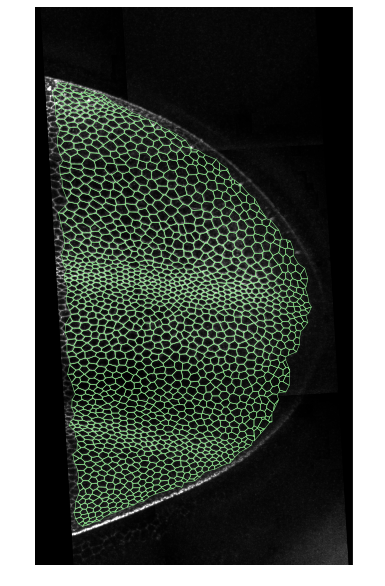

In [14]:
# Image is revesred because coordinate system of the image has y-axis pointing down - we have to reverse y-axis!

frame= 100

movie.frame_cellshapes= tml.subset_dataframe(movie.cellshapes, ['frame'], [frame])

movie.frame_polygons= movie.frame_cellshapes.groupby('cell_id').apply(lambda x: zip(x['x_pos'].values, x['y_pos'].values)).reset_index().rename(columns= {0: 'plot_vertices'})

plt.figure(figsize= (6, 10))
movie.show_image(frame)                                                      
plt.gca().autoscale_view()                                                  
plt.gca().set_aspect('equal')                                                
coll= mc.PolyCollection(movie.frame_polygons['plot_vertices'].values, lw= .5)         
coll.set_edgecolor('lightgreen')
coll.set_facecolor('none')
plt.gca().add_collection(coll)                                              
plt.xlim(0, 900)                                                           
plt.ylim(300, 1800)                                                                                                              
plt.axis('off')      
plt.gca().invert_yaxis()  # Inverting the y-axis of the plot
plt.savefig(outDatabaseDir+'cell_outlines.png')

## 2.1 Cell area

In [15]:
# Preparind the data in frame 70 for visualization.
frame= 70

# To visualise cells we subset cellshapes table (loaded in Introduction) by the frame
movie.frame_cellshapes= tml.subset_dataframe(movie.cellshapes, ['frame'], [frame])

# Construct a list of polygon vertices for each cell
movie.frame_polygons= movie.frame_cellshapes.groupby('cell_id').apply(lambda x: zip(x['x_pos'].values, x['y_pos'].values)).reset_index().rename(columns= {0: 'plot_vertices'})

# We subset movie.DB_table['cells'] DataFrame to select cells in a given frame
movie.frame_cells= tml.subset_dataframe(movie.DB_table['cells'], ['frame'], [frame])

# Add the cell area information to the frame_polygons table
movie.frame_polygons= movie.frame_polygons.merge(movie.frame_cells[['cell_id', 'realArea']], on= 'cell_id')

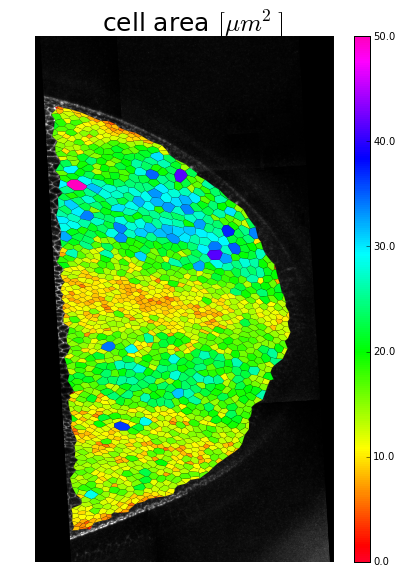

In [16]:
# To visualise cell area we use method Movie.plot_frame_cells()
movie.plot_frame_cells(frame, movie.frame_polygons, title= 'cell area $[\mu m^2]$', color_column= 'realArea', c_min= 0, c_max= 50, color_map= cm.gist_rainbow)
plt.savefig(outDatabaseDir+'cell_area_frame_' + tml.fill_zeros(str(frame), 3) + '.png')

## 2.2 Cell elongation

In [17]:
# Preparind the data in frame 70 for visualization.
frame= 70

movie.frame_cellshapes= tml.subset_dataframe(movie.cellshapes, ['frame'], [frame])

movie.frame_polygons= movie.frame_cellshapes.groupby('cell_id').apply(lambda x: zip(x['x_pos'].values, x['y_pos'].values)).reset_index().rename(columns= {0: 'plot_vertices'})

movie.frame_cells= tml.subset_dataframe(movie.DB_table['cells'], ['frame'], [frame])

movie.frame_polygons= movie.frame_polygons.merge(movie.frame_cells[['cell_id', 'elong_xx']], on= 'cell_id')

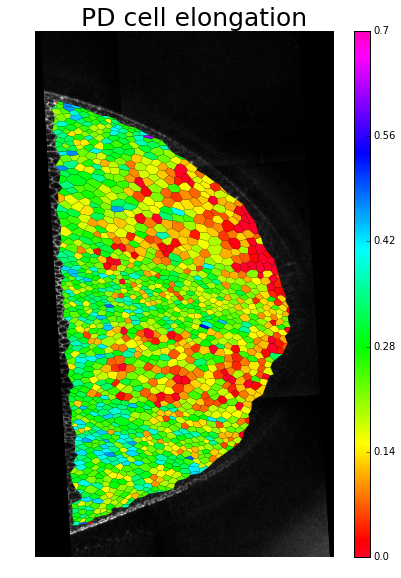

In [18]:
movie.plot_frame_cells(frame, movie.frame_polygons, title= 'PD cell elongation', color_column= 'elong_xx', c_min= 0, c_max= .7, color_map= cm.gist_rainbow)
plt.savefig(outDatabaseDir+'cell_elong_frame_' + tml.fill_zeros(str(frame), 3) + '.png')

## 2.3 Cell packing 

In [19]:
# To determine number of neighbor for each cell we need to load 'directed bonds' table and store it 
# in movie.DB_table['directed_bonds'] DataFrame
movie.load_DB_table('directed_bonds')

movie.DB_table['directed_bonds'].head()

Loading table directed_bonds from pickle file...


,frame,cell_id,dbond_id,conj_dbond_id,bond_id,vertex_id,left_dbond_id
0,0,10001,1130,1129,567,393,1312
1,0,10001,1236,1235,620,427,1130
2,0,10001,1312,1311,658,392,1439
3,0,10001,1439,1441,722,452,1442
4,0,10001,1442,1443,723,493,1444


In [20]:
# Preparing the data in frame 70 for visualization.
frame= 70

# We subset movie.DB_table['directed_bonds'] DataFrame to select bonds in a given frame
movie.frame_dbonds= tml.subset_dataframe(movie.DB_table['directed_bonds'], ['frame'], [frame])

In [21]:
# Number of neighbors is equal to number of bonds of each cell. Therefore we group rows of movie.frame_dbonds
# DataFrame by cell_id and we assing to each cell_id number of element in the corresponding group
movie.frame_cell_packing= movie.frame_dbonds[['cell_id', 'dbond_id']].groupby('cell_id').agg(len).reset_index().rename(columns= {'dbond_id': 'nr_neighbors'})

movie.frame_cell_packing.head()

,cell_id,nr_neighbors
0,10002,5
1,10003,6
2,10011,5
3,10022,7
4,10033,6


In [22]:
movie.frame_polygons= movie.frame_cellshapes.groupby('cell_id').apply(lambda x: zip(x['x_pos'].values, x['y_pos'].values)).reset_index().rename(columns= {0: 'plot_vertices'})

# As before, we add information about number of neighbors to movie.frame_polygons DataFrame 
movie.frame_polygons= movie.frame_polygons.merge(movie.frame_cell_packing, on= 'cell_id')

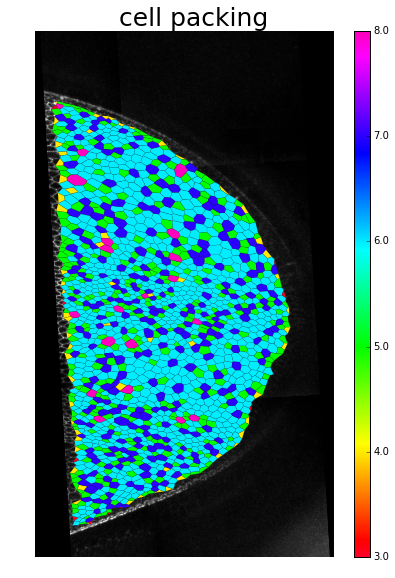

In [23]:
movie.plot_frame_cells(frame, movie.frame_polygons, title= 'cell packing', color_column= 'nr_neighbors', c_min= 3., c_max= 8., color_map= cm.gist_rainbow)
plt.savefig(outDatabaseDir+'cell_packnig_frame_' + tml.fill_zeros(str(frame), 3) + '.png')

## 2.4 Cell division patterns

In [24]:
# To visualize division patterns we will show to which generation each cell belongs. This information is  
# available in 'cell_histories' table of SQL database.

movie.load_DB_table('cell_histories')

movie.DB_table['cell_histories'].head()

Loading table cell_histories from pickle file...


,cell_id,tissue_analyzer_group_id,first_occ,last_occ,left_daughter_cell_id,right_daughter_cell_id,appears_by,disappears_by,lineage_group,generation
0,10001,1265,0,20,NaN,NaN,Unclassified,Apoptosis,lg_2,0
1,10002,28170,0,177,NaN,NaN,Unclassified,MovesOutOfMask,lg_3,0
2,10003,52814,0,106,NaN,NaN,Unclassified,MovesOutOfMask,lg_4,0
3,10004,64282,0,3,11124,11125,Unclassified,Division,lg_5,0
4,10005,78460,0,6,NaN,NaN,Unclassified,MovesOutOfMask,lg_6,0


In [25]:
# Combine generatino information with frame_cells table

# In this example we show late because it shows cumulative division pattern.
frame= 170

movie.frame_cellshapes= tml.subset_dataframe(movie.cellshapes, ['frame'], [frame])

movie.frame_polygons= movie.frame_cellshapes.groupby('cell_id').apply(lambda x: zip(x['x_pos'].values, x['y_pos'].values)).reset_index().rename(columns= {0: 'plot_vertices'})

movie.frame_polygons= movie.frame_polygons.merge(movie.DB_table['cell_histories'][['cell_id', 'generation']], on= 'cell_id')

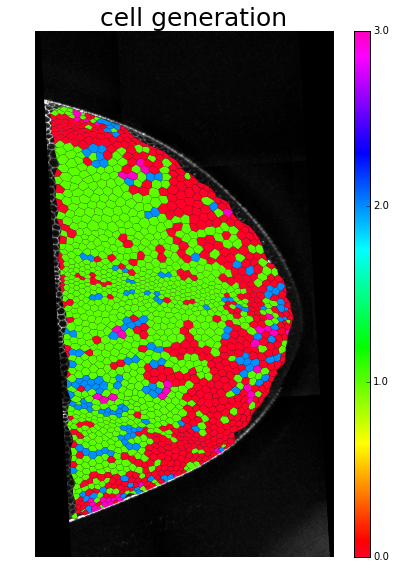

In [26]:
movie.plot_frame_cells(frame, movie.frame_polygons, title= 'cell generation', color_column= 'generation', c_min= 0., c_max= 3., n_ticks= 3,color_map= cm.gist_rainbow)
plt.savefig(outDatabaseDir+'cell_division_pattern_frame_' + tml.fill_zeros(str(frame), 3) + '.png')

# 3 Comparing average quantities among movies and ROIs
Data produced by TissueMiner is easy to compare among different movies and regions of interest. Here we first demonstrate the comparison of total cell number in three provided movies and then we compare average cell area and elongation between the three movies in different regions of interest.

In [27]:
# Define a list of movies to compare

movie_list= ['WT_1',
             'WT_2',
             'WT_3']

# Define a list of ROIs to analyse
ROI_list= ['whole_tissue', 'distL3', 
           'distInterL2-L3', 'distInterL3-L4']

In [28]:
movies= {}  # Dictionary to store instances of Movie class for different movies - contains all the data we will use.

for name in movie_list:
    print name
    movies[name]= tm.Movie(name, path= movieDatabaseDir, ROI_path= movieRoiPath, ROI_filename= movieRoiFile)

WT_1
Loading table frames from database WT_1...
Loading table cells from pickle file...
Loading roiBT ...
WT_2
Loading table frames from database WT_2...
Loading table cells from pickle file...
Loading roiBT ...
WT_3
Loading table frames from database WT_3...
Loading table cells from pickle file...
Loading roiBT ...


## 3.1 Cell count for different movies

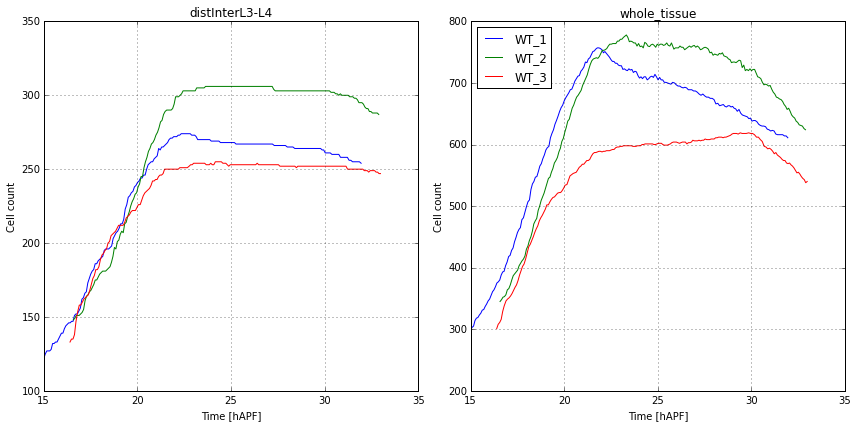

In [29]:
# We determine number of cells in 'blade' and 'whole_tissue' regions of interest using method Movie.cell_number(region).
for name in movie_list:
    movies[name].blade_nr_cells= tml.cells_number(movies[name].region_cells('distInterL3-L4'))
    movies[name].whole_tissue_nr_cells= tml.cells_number(movies[name].region_cells('whole_tissue'))

plt.figure(figsize= (12, 6))    
plt.subplot(1, 2, 1)
for name in movie_list:
    plt.plot(movies[name].time[:movies[name].NFrames], movies[name].blade_nr_cells, label= name)
plt.grid()
plt.title('distInterL3-L4')
plt.xlabel('Time [hAPF]')
plt.ylabel('Cell count')
plt.subplot(1, 2, 2)
for name in movie_list:
    plt.plot(movies[name].time[:movies[name].NFrames], movies[name].whole_tissue_nr_cells, label= name)
plt.grid()
plt.title('whole_tissue')
plt.xlabel('Time [hAPF]')
plt.ylabel('Cell count')
plt.legend(loc= 'best')
plt.tight_layout()
plt.savefig(outDatabaseDir+'cell_count_comparison.png')

## 3.2 Average cell area in different ROIs and movies

In [30]:
# Calculate average cell area for each ROI of each movie using region_cells_area_avg from tissue_miner_tools.py.
# Conversion factor 0.207 from pixels to micrometers is included.

for name in movie_list:
    movies[name].average_cell_area= {}

for region in ROI_list:
    for name in movie_list:
        movies[name].average_cell_area[region]= tml.cells_average_area(movies[name].region_cells(region))*.207**2

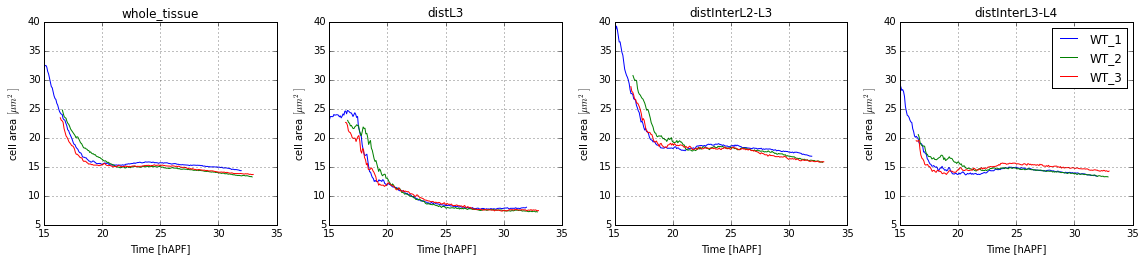

In [31]:
plt.figure(figsize= (16, 10))
for region in ROI_list:
    plt.subplot(3, 4, 1 + ROI_list.index(region))
    for name in movie_list:
        plt.plot(movies[name].time[:movies[name].NFrames], movies[name].average_cell_area[region], label= name)
    plt.ylim(5, 40)
    plt.xlabel('Time [hAPF]')
    plt.ylabel('cell area $[\mu m^2]$')
    plt.title(region)
    plt.grid()
plt.legend(loc= 'best')
plt.tight_layout()
plt.savefig(outDatabaseDir+'cell_average_area_ROI_comparison.png')

## 3.3 Norm of  average cell elongation in different ROIs and movies

In [32]:
# Calculate average cell elongation for each ROI of each movie using region_cel_shape_avg() function from tissue_miner_tools.py

for name in movie_list:
    movies[name].average_cell_elong_xx= {}
    movies[name].average_cell_elong_xy= {}

for region in ROI_list:
    for name in movie_list:
        (movies[name].average_cell_elong_xx[region], 
         movies[name].average_cell_elong_xy[region])= tml.cells_average_elongation(movies[name].region_cells(region))

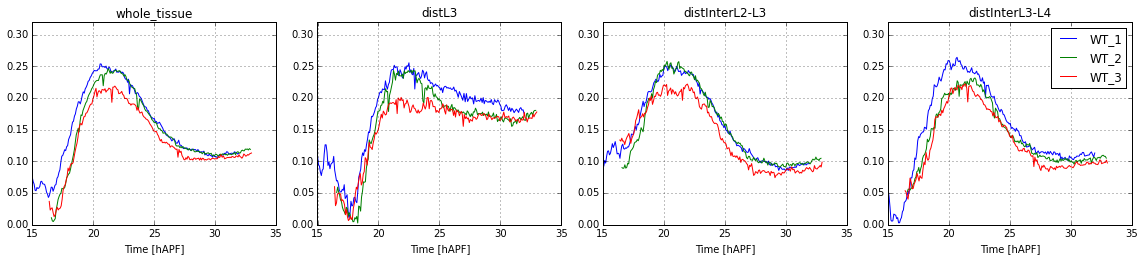

In [33]:
plt.figure(figsize= (16, 10))
for region in ROI_list:
    plt.subplot(3, 4, 1 + ROI_list.index(region))
    for name in movie_list:
        plt.plot(movies[name].time[:movies[name].NFrames], 
                 np.sqrt(movies[name].average_cell_elong_xx[region]**2 +
                         movies[name].average_cell_elong_xy[region]**2), label= name)
        plt.ylim(0, 0.32)
    plt.title(region)
    plt.xlabel('Time [hAPF]')
    plt.grid()
plt.legend(loc= 'best')
plt.tight_layout()
plt.savefig(outDatabaseDir+'cell_average_elong_ROI_comparison.png')